# Numerical Approximation Methods

The reason I'm doing this with Python is because I want to become more comfortable with the construction of many numerical approximation methods.

## Contents
1. [Initial Value Problems of the First Order](#Initial-Value-Problems-of-the-First-Order)
    1. [First Order Euler Method](#First-Order-Euler-Method)
    1. [Second Order Euler Method](#Second-Order-Euler-Method)
    1. [Runge-Kutta Method](#Runge-Kutta-Method)
    1. [Method Constructors](#Method-Constructors)

In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

## Initial Value Problems of the First Order
We will compare the accuracy of numerical approximation methods with varying timesteps.

In [2]:
# create initial conditions
df = lambda t, x: - np.power(x, 2)
initial_value = 1

# create resolution space
nn = [i for i in range(2, 10)]
ntt = [np.linspace(0, 1, n) for n in nn]
nss = [[None for _ in tt] for tt in ntt]

# create different colors for each resolution
ncolor = cm.rainbow(np.linspace(0, 1, len(nn)))

### First Order Euler Method
Consider the differential equation $\dot{x(t)} = f(t, x(t))$. The first-order Euler's method with timestep $h$ is $x' = x + hf(t, x)$, where $x'$ is the approximated value of $x$ at the incremented time $t + h$.

We consider the autonomous differential equation $\dot{x} = -x^2$, with initial condition $x(0) = 1$. Therefore, the function in question is $f(t, x) = -x^2$.

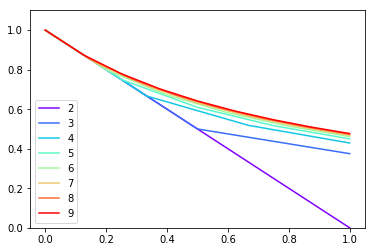

In [3]:
# iterate over different resolutions (using the first order Euler method).
for i, tt in enumerate(ntt):
    dt = (tt[-1] - tt[0]) / (len(tt) - 1)
    
    for j, t in enumerate(tt):
        if j == 0:
            nss[i][j] = initial_value
            pass
        else:
            # application of first-order euler method.
            nss[i][j] = nss[i][j-1] + df(t, nss[i][j-1])*dt
            pass
        pass
    plt.plot(tt, nss[i], label = '{}'.format(nn[i]), color = ncolor[i])
    pass
plt.ylim(0, 1.1)
plt.legend()
plt.show()

### Second Order Euler Method

Using Taylor's expansion, a second-order Euler approximation is $x' = x + h\dot{x} + \dfrac{h^2}{2}\ddot{x}$.

Since $\dot{x} = -x^2$, then $\ddot{x} = \dfrac{d}{dt}(-x^2) = -2x\dot{x} = -2x(-x^2) = 2x^3$. Let $g(t, x) = 2x^3$ be our second-order Euler function, then our approximation reduces to $x' = x - hx^2 + h^2x^3$.

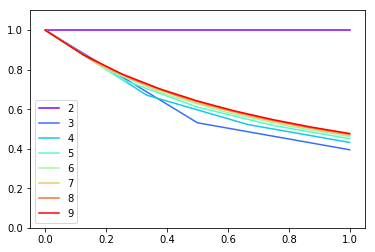

In [4]:
# define second-order term
ddf = lambda t, x:2*np.power(x, 3)

# iterate over different resolutions (using the second order Euler method).
for i, tt in enumerate(ntt):
    dt = (tt[-1] - tt[0]) / (len(tt) - 1)
    
    for j, t in enumerate(tt):
        if j == 0:
            nss[i][j] = initial_value
            pass
        else:
            # application of second-order euler method.
            nss[i][j] = nss[i][j-1] + df(t, nss[i][j-1])*dt + np.power(dt, 2)/2*ddf(t, nss[i][j-1]*dt)
            pass
        pass
    plt.plot(tt, nss[i], label = '{}'.format(nn[i]), color = ncolor[i])
    pass
plt.ylim(0, 1.1)
plt.legend()
plt.show()

### Runge-Kutta Method
The RK method states that $y' = y + \dfrac{1}{6}(k_1 + 2k_2 + 2k_3 + k_4)$, where $k_1 = hf(t_n, y_n)$, $k_2 = hf\bigg(t_n + \dfrac{h}{2}, y_n + \dfrac{k_1}{2}\bigg)$, $k_3 = hf\bigg(t_n + \dfrac{h}{2}, y_n + \dfrac{k_2}{2}\bigg)$, and $k_4 = hf(t_n + h, y_n + k_3)$.

### Method Constructors
We note that in all three approximation procedures, the method is applied in only one part of the algorithm. Hence, we can isolate the methods by defining their *constructors*, which take in all relevant functions and the timestep, and return *functions*, which take in only the current time and point in space.

For purposes of our experiment, we compute all our derivatives by hand.

In [5]:
from scipy.special import gamma

In [6]:
def euler_method_constructor(ff):
    # computes using euler method of order equal to length of function list.
    
    if not isinstance(ff, list):
        raise TypeError('ff must be list of functions.')
        pass
    
    # find order of ff.
    order = len(ff)
    
    # return a function which works for a given stepsize.
    def euler_method_stepsize(h):
        
        # return a function which, at a stepsize, returns next value.
        def euler_method_function(t, x):
            return x + sum(ff[i](t, x)*np.power(h, i + 1)/gamma(i + 1) for i in range(order))
        return euler_method_function
    return euler_method_stepsize

def runge_kutta_constructor(f):
    # constructs a function according to the rk4 algorithm.
    
    def runge_kutta_stepsize(h):
        def runge_kutta_function(t, x):
            k1 = h*f(t, x)
            k2 = h*f(t + h/2, x + k1/2)
            k3 = h*f(t + h/2, x + k2/2)
            k4 = h*f(t + h, x + k3)
            return x + 1/6*(k1 + 2*k2 + 2*k3 + k4)
        return runge_kutta_function
    return runge_kutta_stepsize

Next, we define a `solve` function, which takes in a constructor, an initial value `x_init`, a linear time array `tt`.

In [7]:
def solve(constructor, x_init, tt):
    
    # extract data from time.
    n = len(tt)
    t_min, t_max = tt[0], tt[n-1]
    h = (t_max - t_min) / (n - 1)
    
    # construct function with stepsize h.
    d_function = constructor(h)
    
    # create solution sequence.
    solution = [None for _ in range(n)]
    
    # build solutions.
    for i, t in enumerate(tt):
        if i == 0:
            solution[0] = x_init
            pass
        else:
            solution[i] = d_function(t, solution[i - 1])
            pass
        pass
    return solution

A comparison of the first-order, second-order Euler methods, and the RK4 method.

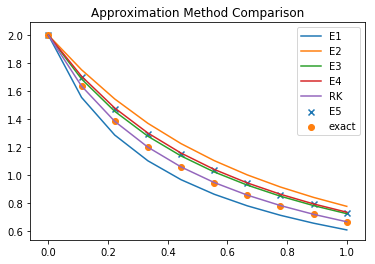

In [8]:
tt = np.linspace(0, 1, 10)
x_init = 2

euler_1 = solve(euler_method_constructor([lambda t, x:-np.power(x, 2)]), x_init, tt)
euler_2 = solve(euler_method_constructor([lambda t, x:-np.power(x, 2), lambda t, x:2*np.power(x, 3)]), x_init, tt)

euler_3 = solve(euler_method_constructor([
    lambda t, x:-np.power(x, 2),
    lambda t, x:2*np.power(x, 3),
    lambda t, x:-6*np.power(x, 4)
]), x_init, tt)
euler_4 = solve(euler_method_constructor([
    lambda t, x:-np.power(x, 2),
    lambda t, x:2*np.power(x, 3),
    lambda t, x:-6*np.power(x, 4),
    lambda t, x:24*np.power(x, 5)
]), x_init, tt)
euler_5 = solve(euler_method_constructor([
    lambda t, x:-np.power(x, 2),
    lambda t, x:2*np.power(x, 3),
    lambda t, x:-6*np.power(x, 4),
    lambda t, x:24*np.power(x, 5),
    lambda t, x:-120*np.power(x, 6)
]), x_init, tt)

rk = solve(runge_kutta_constructor(lambda t, x:-np.power(x, 2)), x_init, tt)
exact = x_init/(1 + x_init*tt)

for i, sol in enumerate(zip([euler_1, euler_2, euler_3, euler_4, euler_5, rk, exact],
                            ['E1', 'E2', 'E3', 'E4', 'E5', 'RK', 'exact'])):
    if i == 6:
        plt.scatter(tt, sol[0], label = '{}'.format(sol[1]))
        pass
    elif i == 4:
        plt.scatter(tt, sol[0], label = '{}'.format(sol[1]), marker = 'x')
    else:
        plt.plot(tt, sol[0], label = '{}'.format(sol[1]))
        pass
    pass
plt.title('Approximation Method Comparison')
plt.legend()
plt.show()